In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.colors as colors
from plotly.subplots import make_subplots

# EDA (pandas-profiling, etc. )
import scipy.stats as stats
from statsmodels.tsa.stattools import kpss
from scipy.stats import t, ttest_ind, chi2_contingency


# Feature Processing (Scikit-learn processing, etc. )
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )


# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )


# Other packages
import pickle

In [4]:
holidays=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv", parse_dates =['date'])
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates =['date'])
sample=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
test=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates =['date'])
train=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", parse_dates =['date'])
transactions=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv", parse_dates =['date'])

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



# Feature	Description

1. store_nbr: identifies the store at which the products are sold.
2. family: identifies the type of product sold.
3. sales: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
4. onpromotion: gives the total number of items in a product family that were being promoted at a store at a given date.

In [6]:
# Check for missing values using isna()
missing_values = train.isna().sum()

# Count missing values in each column
missing_counts = missing_values.sum()

# Check if there are any missing values in the entire DataFrame
any_missing = missing_values.any().any()

print("Missing Values in DataFrame:")
print(missing_values)
print("\nMissing Value Counts in Each Column:")
print(missing_counts)
print("\nAre there any missing values in the DataFrame?", any_missing)

Missing Values in DataFrame:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing Value Counts in Each Column:
0

Are there any missing values in the DataFrame? False


In [7]:
# statistics for numerical columns
train.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


Let us start by plotting frequencies of data point on yearly/monthly basis

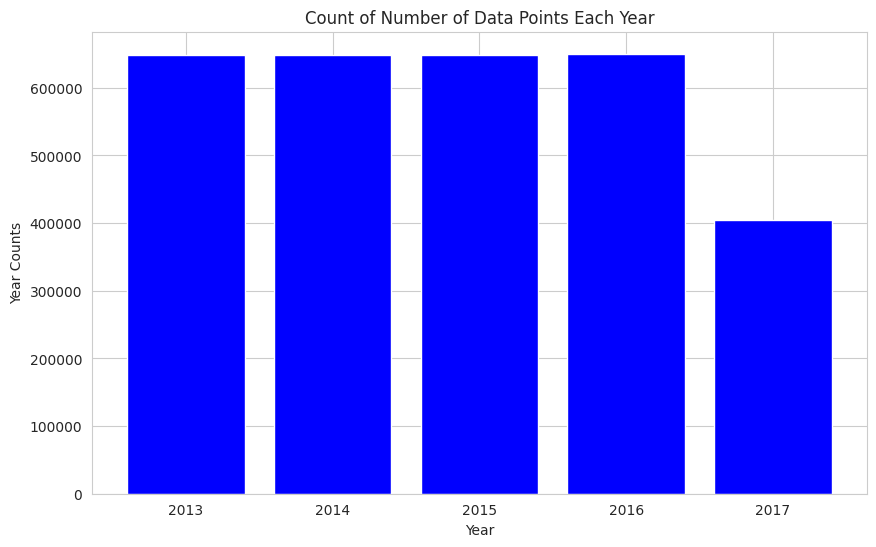

In [8]:
# copy train dataset so that we work with a copy, not the original
train_copy = train.copy()

# extracting the year column
train_copy['year'] = pd.to_datetime(train['date']).dt.year

# Grouping by year and count the data points
year_data = train_copy.groupby('year').size().reset_index(name='counts')

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(year_data['year'], year_data['counts'], color='blue')
ax.set_xticks(year_data['year'])
ax.set_title('Count of Number of Data Points Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Year Counts')

plt.show()

There has been a uniformity of data counts from 2013-2016 but the count dropped in 2017

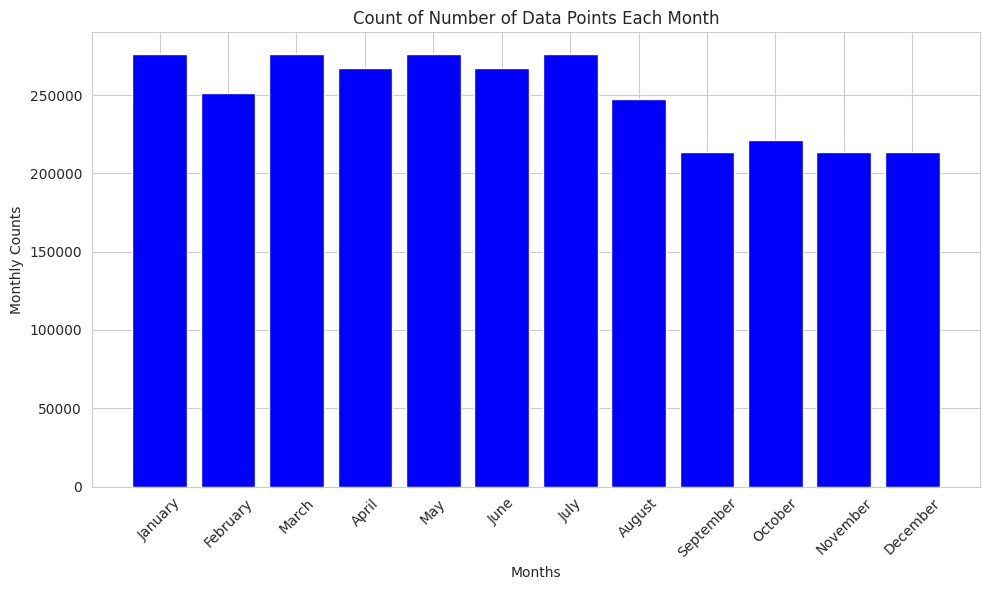

In [9]:
# extracting the month
train_copy['month'] = pd.to_datetime(train_copy['date']).dt.month

# Grouping by month and count the data points
monthly_data = train_copy.groupby('month').size().reset_index(name='counts')

# Renaming the month values for labeling
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_data['month'] = monthly_data['month'].apply(lambda x: month_names[x - 1])

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_data['month'], monthly_data['counts'], color='blue')
ax.set_title('Count of Number of Data Points Each Month')
ax.set_xlabel('Months')
ax.set_ylabel('Monthly Counts')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

# Total sales by store

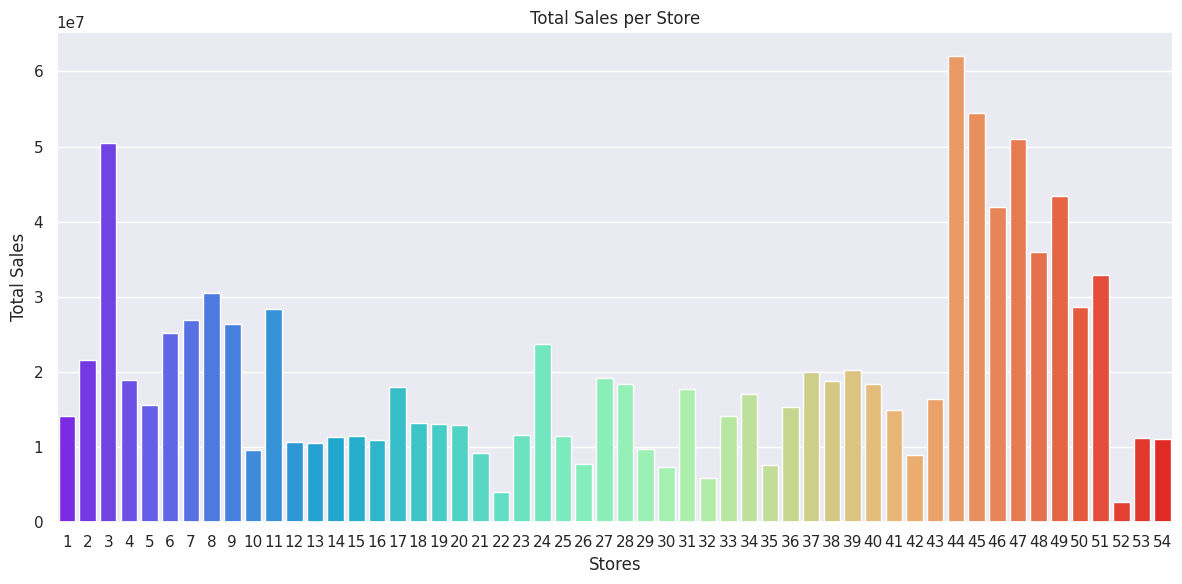

In [10]:
# Filter rows where unit_sales > 0
train_copy = train_copy[train['sales'] > 0]

# Group by 'store_nbr' and calculate the sum of 'unit_sales'
store_unit_sales = train_copy.groupby('store_nbr')['sales'].sum().reset_index()

# Set the figure size
sns.set(rc={'figure.figsize': (12, 6)})

# Create a barplot
sns.barplot(x='store_nbr', y='sales', data=store_unit_sales, palette='rainbow')

# Set titles and labels
plt.title('Total Sales per Store')
plt.xlabel('Stores')
plt.ylabel('Total Sales')

# Show the plot
plt.tight_layout()
plt.show()

We can say Store number 3,44,45,46,47,48,49, 51 have the highest volume of sales

# Unit sales daily

In [11]:
# Filter rows where unit_sales > 0
train_copy = train_copy[train_copy['sales'] > 0]

# Group by 'date' and calculate the sum of 'sales'
sales_date_agg = train_copy.groupby('date')['sales'].sum().reset_index()

# Create a lineplot using Plotly Express
fig = px.line(sales_date_agg, x='date', y='sales', title='Plot of Total Sales Over Time (Daily)')
fig.update_layout(width=1200, height=600)

# Add a range slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
# Show the plot
fig.show()

upward trend year on year

Test data
The test data, has the same features as the training data, except sales, which we will predict the target sales for the dates in this file.

The dates in the test data are for the 15 days after the last date in the training data.

In [12]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [13]:
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [14]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [15]:
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [16]:
# Visualize transactions over the years with plotly

fig = px.line(transactions, y="transactions",x='date', title="Transaction data over time")

# enable range slider with range selector
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Big spikes is transactions in december every year; indicates seasonality

In [17]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [18]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Oil Dataset
Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

In [19]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [20]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

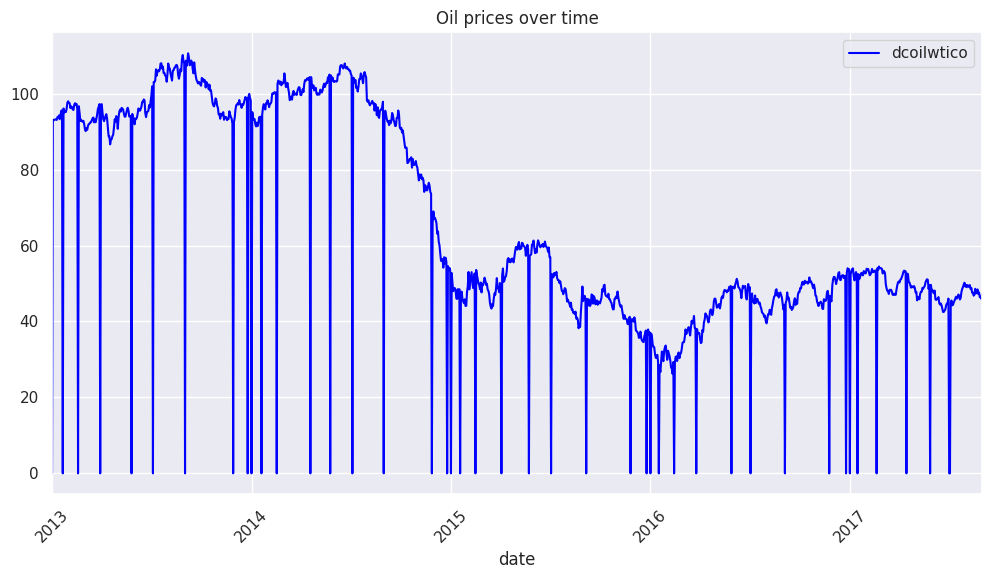

In [21]:
# Oil prices over time

ax = oil.groupby(['date'], as_index=False)["dcoilwtico"].sum().plot(
    "date", "dcoilwtico", figsize=(12,6), title="Oil prices over time", color='blue')

plt.tick_params(axis='x', labelrotation=45)

In [22]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [23]:
holidays.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

# Analytical Questions

## 1. Is the train dataset complete (has all the required dates)?

In [24]:
# Check for missing values
if train.isnull().values.any():
  print("The dataset is not complete. There are missing values.")
else:
  print("The dataset is complete.")

The dataset is complete.


In [25]:
train.date.min(), train.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [26]:
# Actual recorded number of days in train dataset

train['date'].nunique()

1684

In [27]:
# range between min and max dates

min_date = train['date'].min()
max_date = train['date'].max()
days_range = pd.date_range(start=min_date, end=max_date)
num_days = len(days_range)
num_days

1688

In [28]:
expected_dates = pd.date_range(start=min_date, end=max_date)
expected_dates

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [29]:
# Missing dates

missing_dates = expected_dates.difference(train['date'].unique())
missing_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

- The train dataset is mising 4 dates.These missing dates follow a pattern (december 25th) from 2013-2016. This date is a worldwide holiday, and also a holiday in Ecuador.
- The assumption is that no data was collected on this day every year as the shops may be closed down on christmas each year.

In [30]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [32]:
missing_df = list(missing_dates)
print(pd.DataFrame(missing_df))

           0
0 2013-12-25
1 2014-12-25
2 2015-12-25
3 2016-12-25


In [33]:
# Add missing dates in a DataFrame

new_dates = pd.DataFrame(missing_df, columns = ['date'])
new_dates

,date
0,2013-12-25
1,2014-12-25
2,2015-12-25
3,2016-12-25


In [34]:
train = pd.concat([train, new_dates], ignore_index=False)
train

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0
...,...,...,...,...,...,...
3000887,3000887.0,2017-08-15,9.0,SEAFOOD,16.0,0.0
0,NaN,2013-12-25,NaN,NaN,NaN,NaN
1,NaN,2014-12-25,NaN,NaN,NaN,NaN
2,NaN,2015-12-25,NaN,NaN,NaN,NaN


In [35]:
train.isna().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

## 2. Which dates have the lowest and highest sales for each year?

In [36]:
# Highest sales date in each year

train_copy['year'] = train_copy['date'].dt.year
max_sales = train_copy.groupby('year')['sales'].idxmax()
Result_max = train.loc[max_sales]
Result_max

,id,date,store_nbr,family,sales,onpromotion
562596,562596.0,2013-11-12,44.0,GROCERY I,46271.000,0.0
1257246,1257246.0,2014-12-08,35.0,GROCERY I,45361.000,3.0
1916586,1916586.0,2015-12-14,35.0,GROCERY I,40351.460,7.0
2163723,2163723.0,2016-05-02,2.0,GROCERY I,124717.000,59.0
2760297,2760297.0,2017-04-02,9.0,GROCERY I,38422.625,73.0


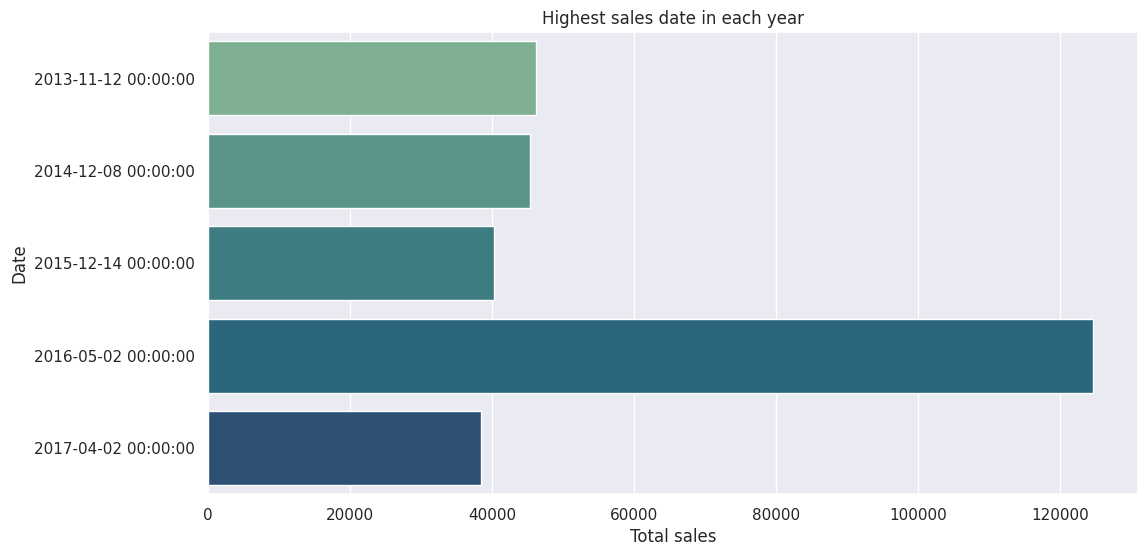

In [37]:
# Horizontal bar chart of dates with highest sales each year

sns.barplot(data=Result_max, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("Highest sales date in each year")
plt.show()

2016(11/12) has the highest number of sales (124,717)

In [38]:
# lowest sales date in each year

min_sales = train_copy.groupby('year')['sales'].idxmin()
Result_min = train.loc[min_sales]
Result_min

,id,date,store_nbr,family,sales,onpromotion
387782,387782.0,2013-08-06,39.0,SEAFOOD,0.122,0.0
1252052,1252052.0,2014-12-05,39.0,SEAFOOD,0.188,0.0
1756358,1756358.0,2015-09-15,39.0,SEAFOOD,0.196,0.0
2256638,2256638.0,2016-06-23,26.0,SEAFOOD,0.396,1.0
2666498,2666498.0,2017-02-09,26.0,SEAFOOD,0.426,0.0


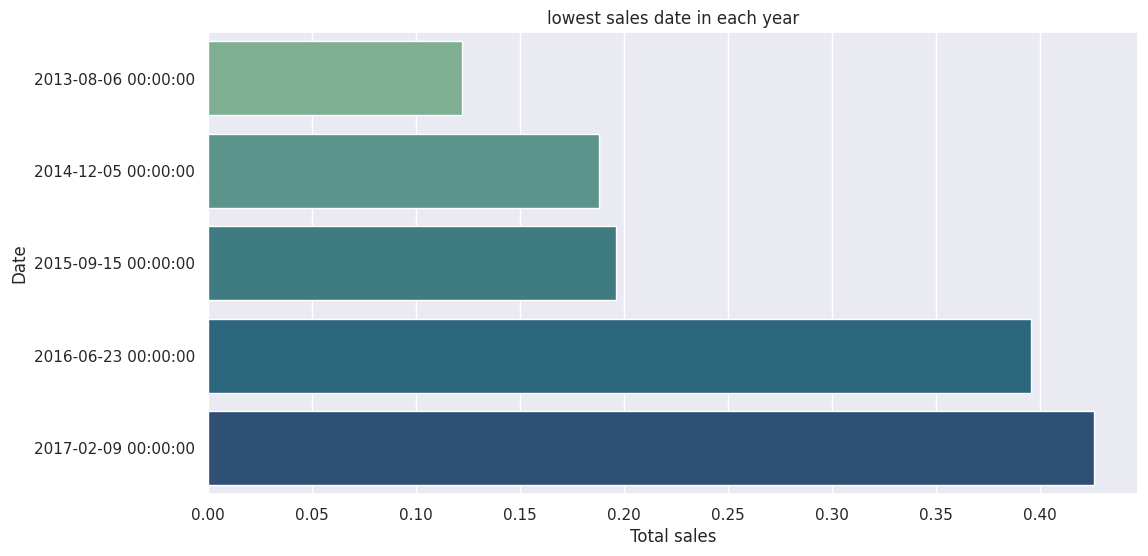

In [39]:

# Horizontal bar chart of dates with lowest sales each year

sns.barplot(data=Result_min, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("lowest sales date in each year")
plt.show()

2013(08/06) has the lowest number of sales (0.12)


## 3. Did the earthquake impact sales?
The 2016 Ecuador earthquake occurred on April 16 at 18:58:37 ECT with a moment magnitude of 7.8

In [40]:

# Set the 'date' column as the index

train_copy.set_index('date', inplace=True)

# Resample to weekly frequency, aggregating with mean

sales_daily_mean = train_copy["sales"].resample('D').mean()
sales_weekly_mean = train_copy["sales"].resample('W').mean()

Text(0.5, 1.0, 'April and May 2016 total sales')

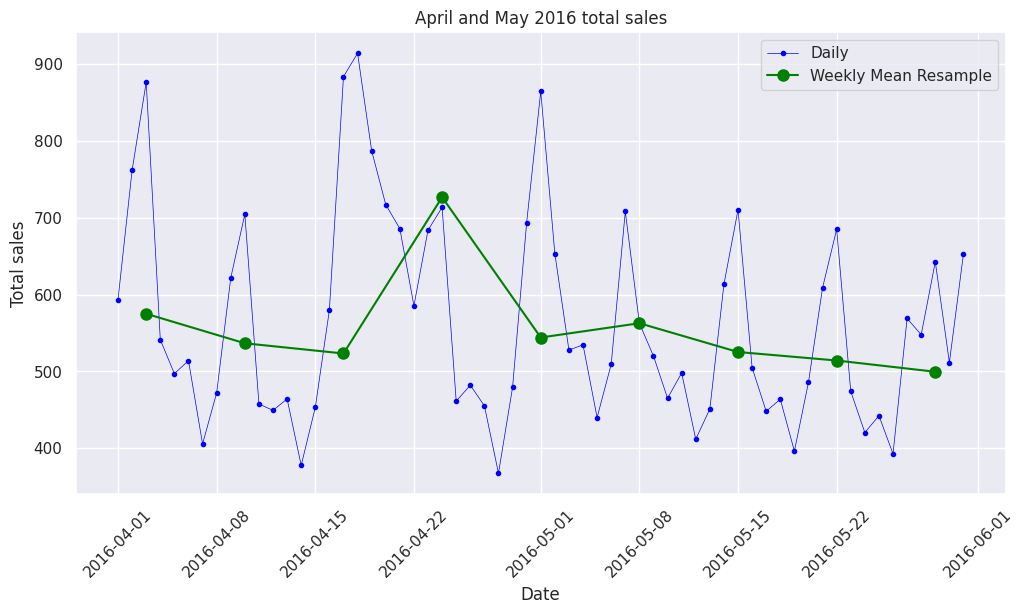

In [41]:
# Sales for April to May 2016.
start, end = '2016-04', '2016-05'

# Analyse before and after the earthquake

fig, ax = plt.subplots(figsize=(12,6))

color_daily = 'blue'
color_weekly = 'green'

ax.plot(sales_daily_mean.loc[start:end], marker='.', linestyle='-', linewidth=0.5, label='Daily', color=color_daily)
ax.plot(sales_weekly_mean.loc[start:end], marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample', color=color_weekly)
ax.set_ylabel("Total sales")
ax.set_xlabel("Date")
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title("April and May 2016 total sales")

In the week of the earthquake (from April 14th to April 21st), sales increased during this week, reaching a peak on the day of the earthquake (16th), but then experienced a sharp decline for nearly two weeks following the earthquake, returning to normalcy.

## 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [42]:
# Merge train and stores datasets

train_stores = pd.merge(train, stores)

train_stores.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,Quito,Pichincha,D,13
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,Quito,Pichincha,D,13
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,Quito,Pichincha,D,13



Store sales by cluster

In [43]:

# Sum of sales by cluster

sales_clusters = train_stores.groupby("cluster", as_index=False)["sales"].sum()
sales_clusters

,cluster,sales
0,1,5.437675e+07
1,2,2.891640e+07
2,3,7.562870e+07
3,4,4.944344e+07
4,5,6.208755e+07
5,6,1.142544e+08
6,7,1.547812e+07
7,8,1.079282e+08
8,9,3.056108e+07
9,10,8.532443e+07


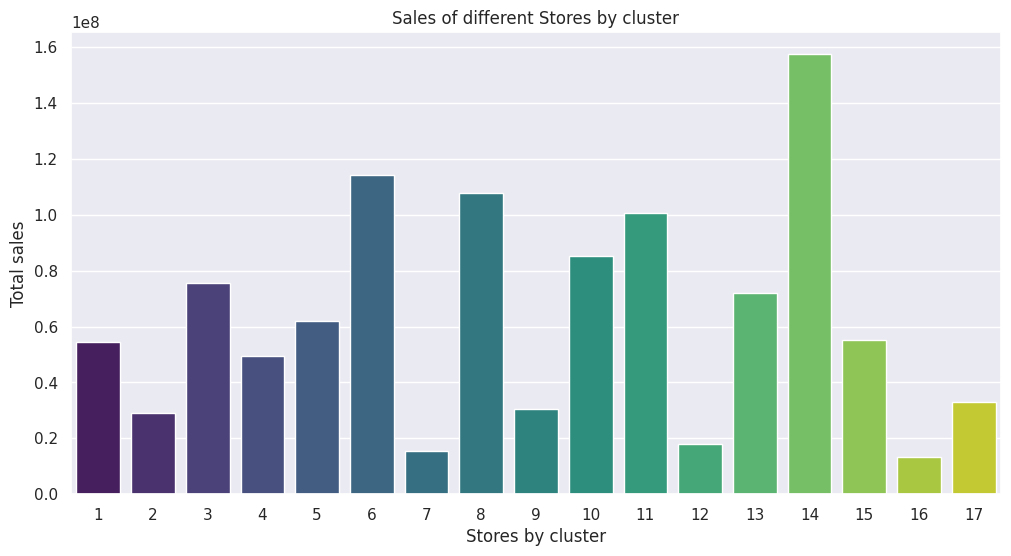

In [44]:
# vertical Bar chart of sales by cluster

ax = sns.barplot(data=sales_clusters, x = "cluster", y = "sales", palette='viridis')
plt.xlabel("Stores by cluster")
plt.ylabel("Total sales")
plt.title("Sales of different Stores by cluster")
plt.show()

cluster 14 has the highest sales. cluster 16 has the lowest sales.

Store sales by city

In [45]:

# Sum of sales by city

sales_city = train_stores.groupby("city", as_index=False)["sales"].sum()
sales_city

,city,sales
0,Ambato,4.030440e+07
1,Babahoyo,1.774687e+07
2,Cayambe,2.832556e+07
3,Cuenca,4.916860e+07
4,Daule,1.918802e+07
5,El Carmen,1.105748e+07
6,Esmeraldas,1.639169e+07
7,Guaranda,1.304951e+07
8,Guayaquil,1.229673e+08
9,Ibarra,1.145127e+07


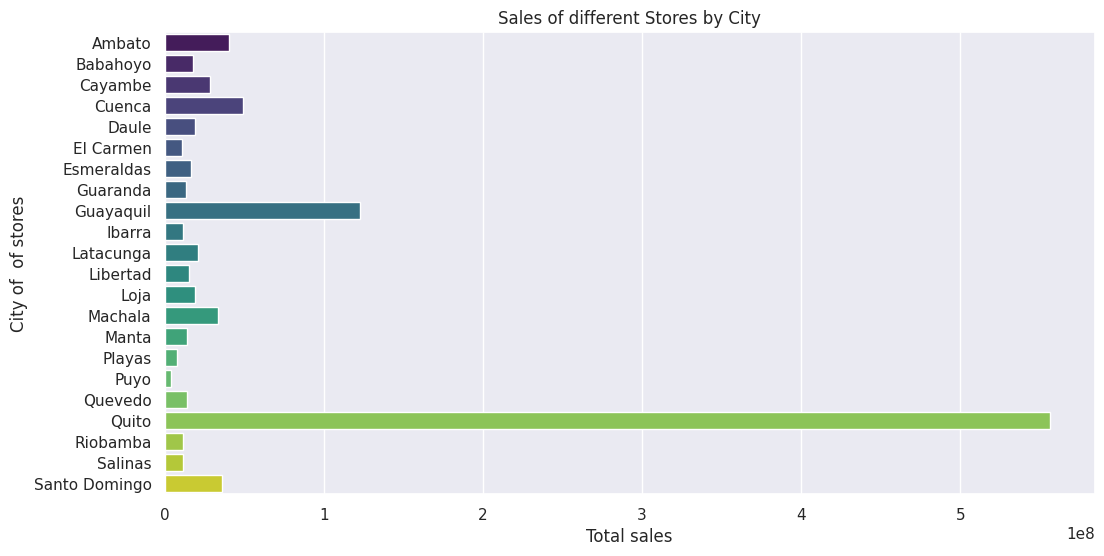

In [46]:
# horizontal Bar chart of sales by city

sns.barplot(data=sales_city, y = "city", x = "sales", palette='viridis')
plt.ylabel("City of  of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by City")
plt.show()


Quito has the highest total sales, as it is the capital, and Puyo the lowest


Store sales by state

In [47]:
# Sum of sales by state

sales_state = train_stores.groupby("state", as_index=False)["sales"].sum()
sales_state

,state,sales
0,Azuay,4.916860e+07
1,Bolivar,1.304951e+07
2,Chimborazo,1.138792e+07
3,Cotopaxi,2.118226e+07
4,El Oro,3.338680e+07
5,Esmeraldas,1.639169e+07
6,Guayas,1.651544e+08
7,Imbabura,1.145127e+07
8,Loja,1.886000e+07
9,Los Rios,3.192537e+07


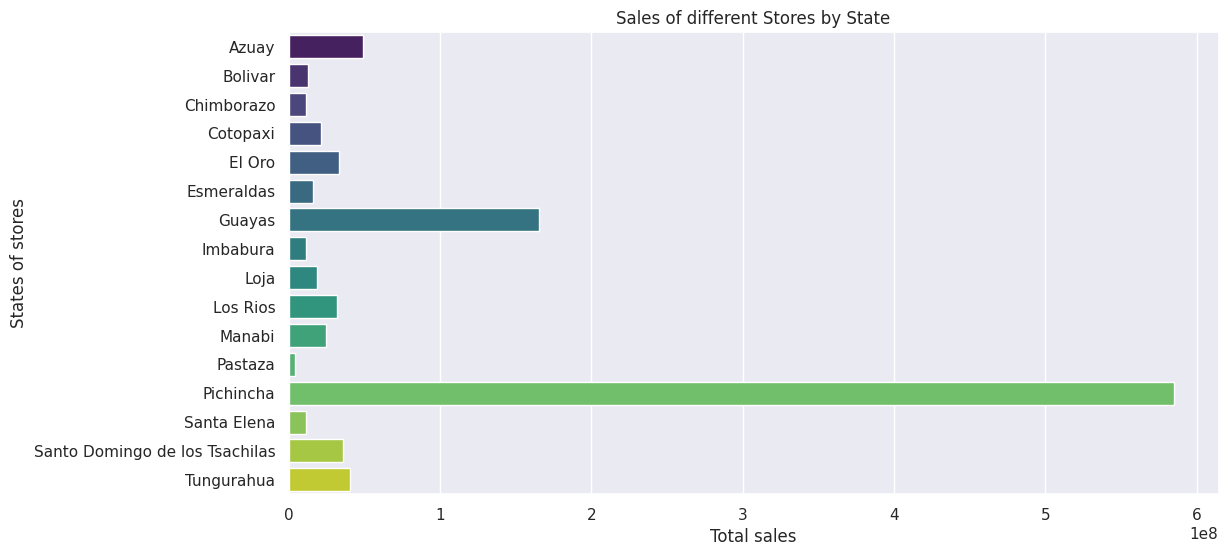

In [48]:
# horizontal Bar chart of sales by state

sns.barplot(data=sales_state, y = "state", x = "sales", palette='viridis')
plt.ylabel("States of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by State")
plt.show()

Pichincha has the highest total sales
Pastaza has the lowest total sales

Store sales by type

In [49]:
# Sum of sales by store type

sales_type = train_stores.groupby("type", as_index=False)["sales"].sum()
sales_type

,type,sales
0,A,3.530438e+08
1,B,1.452606e+08
2,C,1.644347e+08
3,D,3.510833e+08
4,E,5.982244e+07


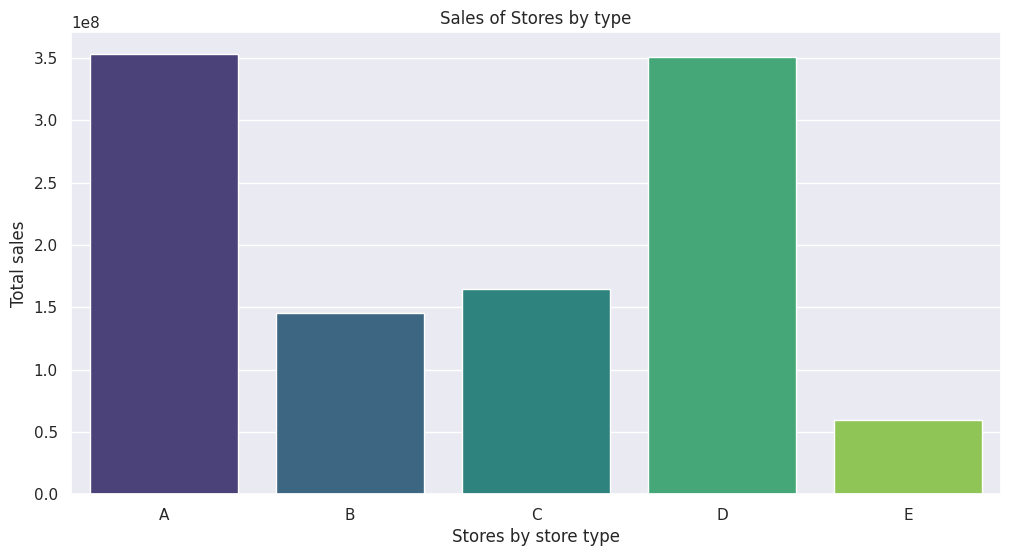

In [50]:
# vertical Bar chart of sales by store type

sns.barplot(data=sales_type, x = "type", y = "sales", palette='viridis')
plt.xlabel("Stores by store type")
plt.ylabel("Total sales")
plt.title("Sales of Stores by type")
plt.show()


type A nd D have the highest total sales

## 5. Are sales affected by promotions, oil prices and holidays?


Sales and promotions

In [51]:
# check unique values product family

train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD', nan], dtype=object)

In [52]:
# Filter rows with promotions and sum sales for top 10 families
promotions = train_copy[train_copy["onpromotion"] != 0].groupby("family")["sales"].sum().sort_values(ascending=False).head(10)

# Filter rows without promotions and sum sales for top 10 families
no_promotions = train_copy[train_copy["onpromotion"] == 0].groupby("family")["sales"].sum().sort_values(ascending=False).head(10)

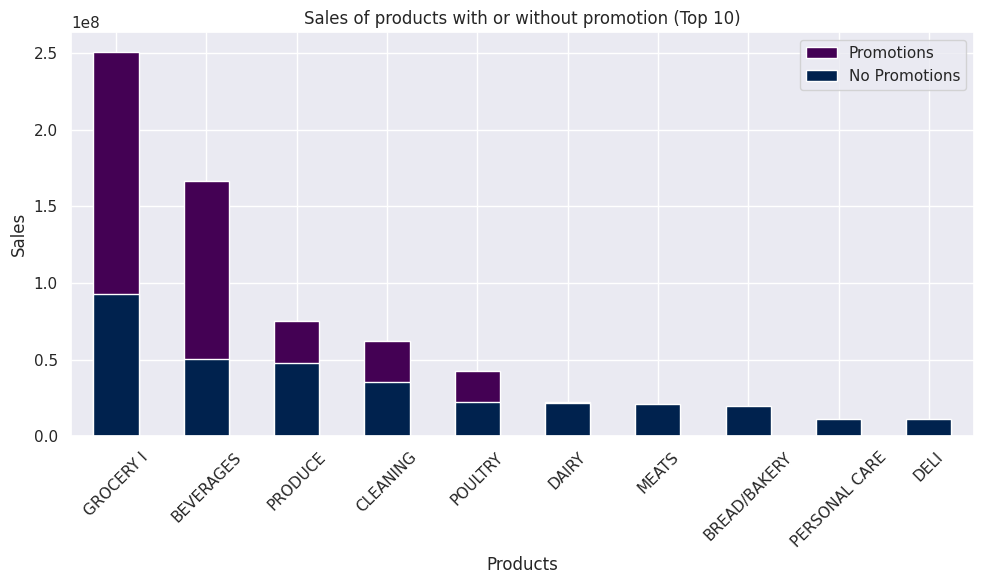

In [53]:
# Create stacked bar chart to visualize sales on and off promotions

ax = promotions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
no_promotions.plot(kind='bar', stacked=True, ax=ax, colormap='cividis')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add legend
plt.legend(["Promotions", "No Promotions"])

# Label the axes and title
plt.ylabel("Sales")
plt.xlabel("Products")
plt.title("Sales of products with or without promotion (Top 10)")

plt.tight_layout()
plt.show()



promotions increases sales for most common purchased items in groceries and beverages category.


Sales and oil prices

In [54]:
# merge train and oil dataset

merge = train_copy.merge(
    oil, 
    how='left', 
    on=['date'])
    
merge.reset_index()
merge.head()

,date,id,store_nbr,family,sales,onpromotion,year,month,dcoilwtico
0,2013-01-01,563,25,BEAUTY,2.000,0,2013,1,NaN
1,2013-01-01,564,25,BEVERAGES,810.000,0,2013,1,NaN
2,2013-01-01,566,25,BREAD/BAKERY,180.589,0,2013,1,NaN
3,2013-01-01,568,25,CLEANING,186.000,0,2013,1,NaN
4,2013-01-01,569,25,DAIRY,143.000,0,2013,1,NaN


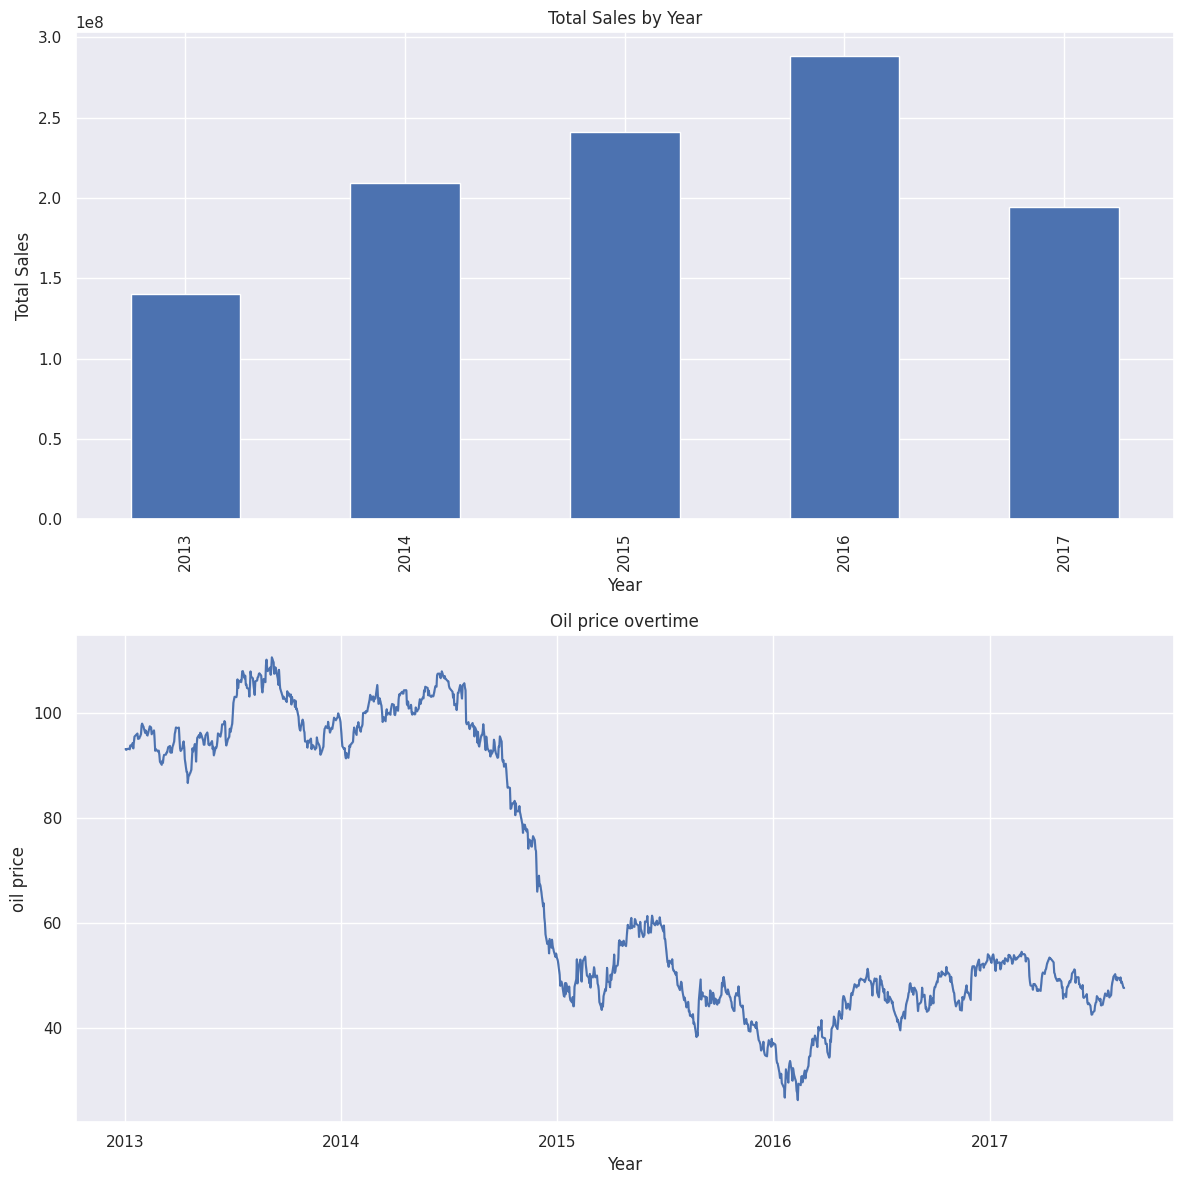

In [55]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the average sales by year 
merge.groupby(['year'])['sales'].sum().plot.bar(ax=ax1, title='Total Sales by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Sales')

# Plot the oil data overtime
sns.lineplot(data=merge, x='date', y='dcoilwtico', ax=ax2)
ax2.set_title('Oil price overtime')
ax2.set_xlabel('Year')
ax2.set_ylabel('oil price')

plt.tight_layout()
plt.show()


Let's see if there is any correlation

In [56]:
# Determine the correlation between sales and oil prices

correlation = merge['sales'].corr(merge['dcoilwtico'])
print(correlation)

-0.030119956091871507


Very weak and almost negligible negative correlation between sales and oil prices over time
Other factors are likely more influential in determining sales than oil prices


Sales and holidays

In [57]:
holidays['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [58]:
# merge train and holidays dataset

merge_2 = train_copy.merge(
    holidays, 
    how='left', 
    on=['date'])
    
merge_2.reset_index()
merge_2.head()

,date,id,store_nbr,family,sales,onpromotion,year,month,type,locale,locale_name,description,transferred
0,2013-01-01,563,25,BEAUTY,2.000,0,2013,1,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,564,25,BEVERAGES,810.000,0,2013,1,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,566,25,BREAD/BAKERY,180.589,0,2013,1,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,568,25,CLEANING,186.000,0,2013,1,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,569,25,DAIRY,143.000,0,2013,1,Holiday,National,Ecuador,Primer dia del ano,False


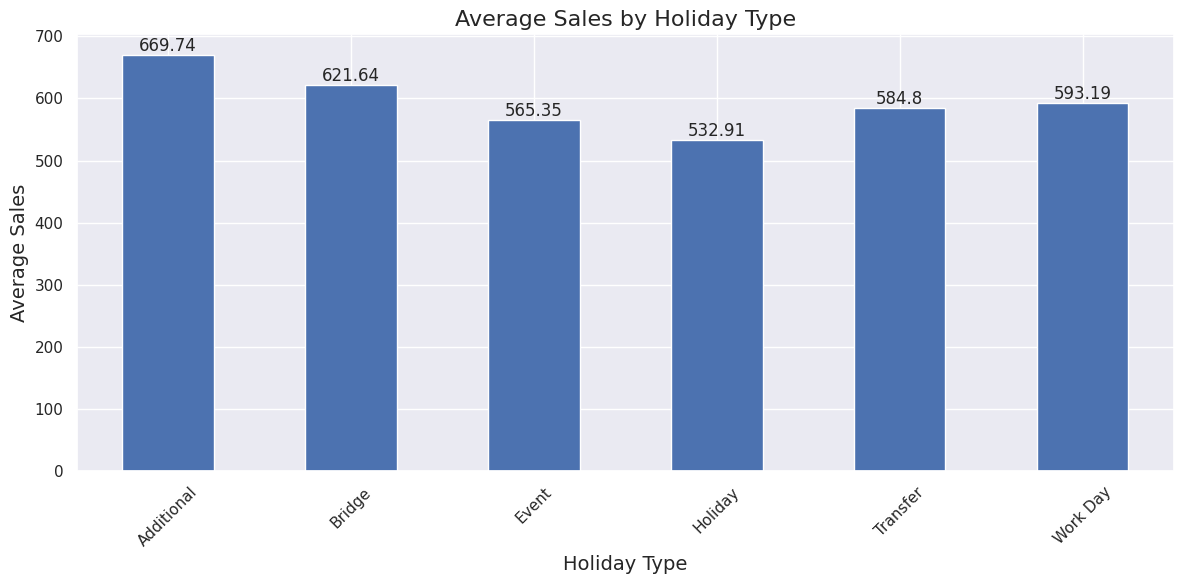

In [59]:
# Group the data by holiday type and calculate the average sales for each type
avg_sales_by_type = merge_2.groupby("type").agg({"sales": "mean"})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot a bar chart of the average sales by holiday type
avg_sales_by_type.plot(kind="bar", y="sales", ax=ax, legend=False)

# Add labels to the bars
for index, value in enumerate(avg_sales_by_type["sales"]):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=12)

# Add a title and labels
ax.set_title("Average Sales by Holiday Type", fontsize=16)
ax.set_xlabel("Holiday Type", fontsize=14)
ax.set_ylabel("Average Sales", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Additional holidays have the highest average sales. However, holiday type barely has an effect on sales

## 6. What analysis can we get from the date and its extractable features?

In [60]:
# Function to extract features from date column

def getDateFeatures(df, date):
    df['date'] = pd.to_datetime(df[date])
    df['month'] = df['date'].dt.month
    df['Month'] = df['date'].dt.month_name()
    df['Day'] = df['date'].dt.day_name()
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df["is_weekend"] = np.where(df['day_of_week'] > 4, 1, 0)
    df['quarter'] = df['date'].dt.quarter
    return df

In [61]:
# run our train data through our function

train_copy = train_copy.reset_index()
train_data = getDateFeatures(train_copy, "date")
train_data.head()

,date,id,store_nbr,family,sales,onpromotion,year,month,Month,Day,day_of_month,day_of_year,week_of_year,day_of_week,is_weekend,quarter
0,2013-01-01,563,25,BEAUTY,2.000,0,2013,1,January,Tuesday,1,1,1,1,0,1
1,2013-01-01,564,25,BEVERAGES,810.000,0,2013,1,January,Tuesday,1,1,1,1,0,1
2,2013-01-01,566,25,BREAD/BAKERY,180.589,0,2013,1,January,Tuesday,1,1,1,1,0,1
3,2013-01-01,568,25,CLEANING,186.000,0,2013,1,January,Tuesday,1,1,1,1,0,1
4,2013-01-01,569,25,DAIRY,143.000,0,2013,1,January,Tuesday,1,1,1,1,0,1



Sales on Pay Day (Semi-Monthly)

In [62]:
# list with semi monthly pay day range (15th and last day 30/31st of the month)

pay_day = pd.date_range(start=train_data.date.min(), end=train_data.date.max(), freq='SM').astype('str').tolist()

In [63]:
# create payday column

train_data["pay_day"] = np.where(train_data["date"].isin(pay_day), 1, 0)
train_data['pay_day'].value_counts()

pay_day
0    1925095
1     136663
Name: count, dtype: int64


We will get the average sales to see wether there is a difference in payday sales and other sales

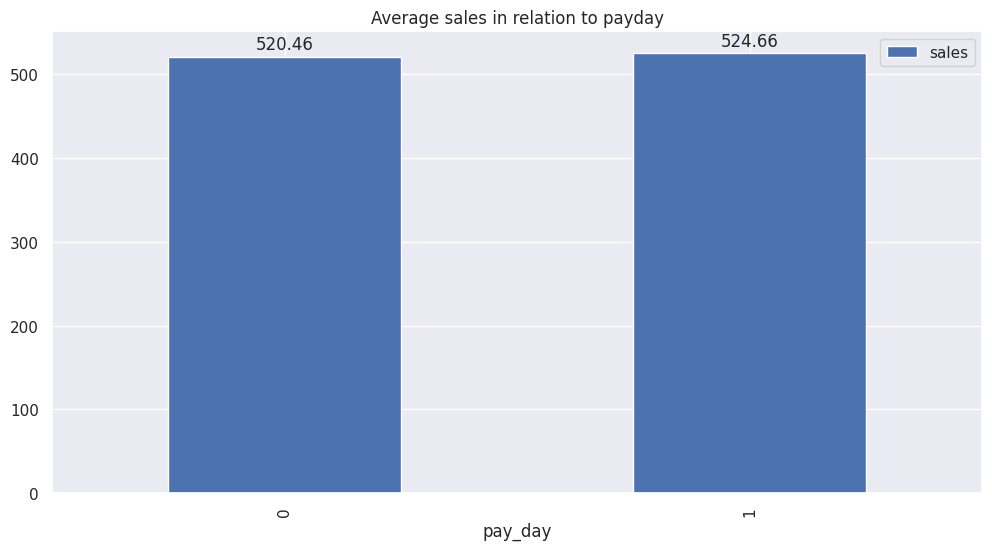

In [64]:
# Plot the average sales in relation to payday

ax = train_data.groupby(["pay_day"], as_index=False)['sales'].mean()\
                                    .plot("pay_day", "sales", kind="bar", figsize=(12,6),
                                         title="Average sales in relation to payday")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


Average payday sales are slightly higher than non-payday sales


Sales by day of the month

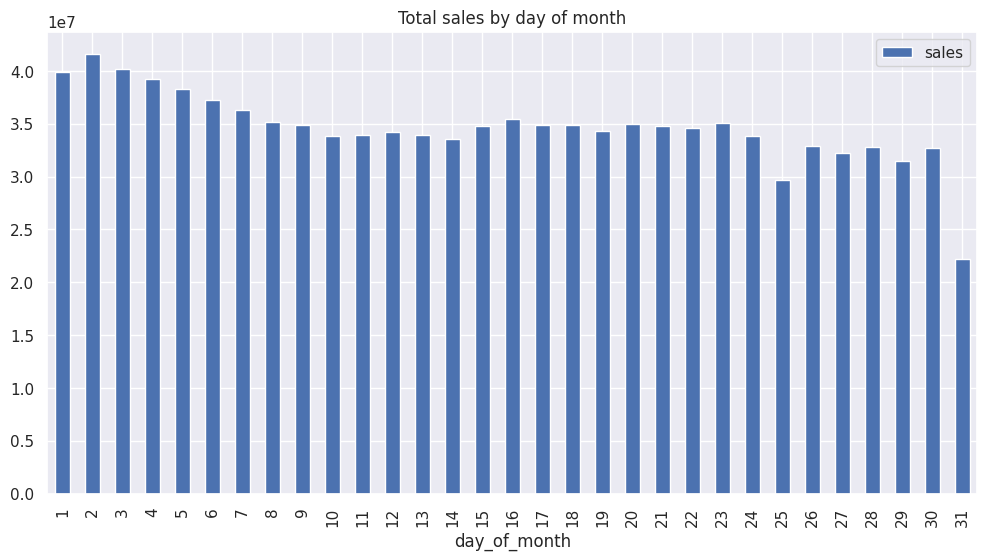

In [65]:
# plot the sum of sales by day of the month
# which day of the month has the most sales?

ax = train_data.groupby(["day_of_month"], as_index=False)["sales"].sum()\
                                    .plot("day_of_month", "sales", kind="bar", figsize=(12,6),
                                         title="Total sales by day of month")

Beginning of the month has high sales (1st - 3rd), with a gradual decline afterwards, but there is an overall uniform trend.


Sales by week of the year

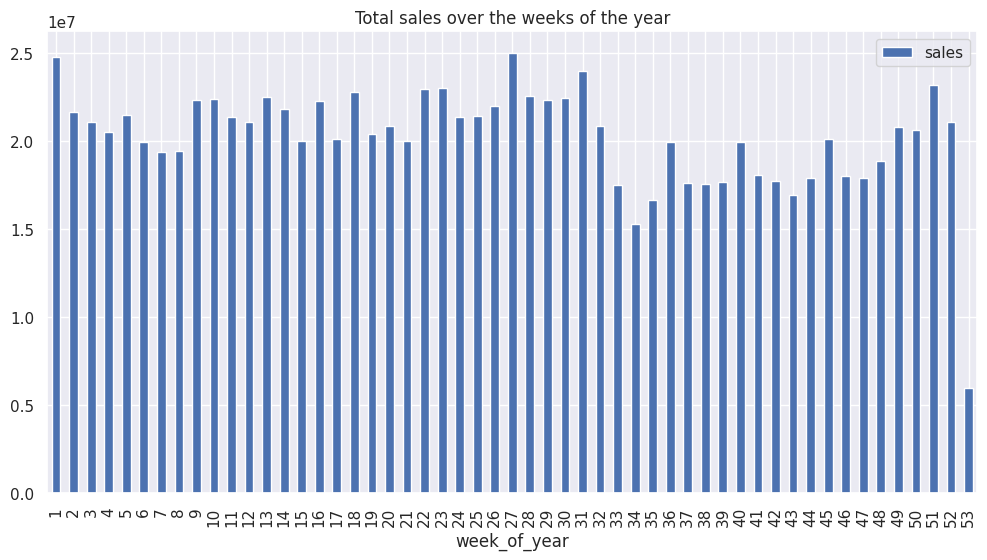

In [66]:
# plot the sum of sales by the weeks of the year

sales_by_week = train_data.groupby(["week_of_year"], as_index=False)['sales'].sum()

ax = sales_by_week.plot("week_of_year", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the weeks of the year")

First week and mid year (week 27) have the highest sales

Sales by month

In [67]:
# group the sum of sales by month of the year
# which month has the highest sales?

purchase_month = train_data.groupby("Month", as_index=False)["sales"].sum().sort_values(by="sales", ascending=False)
purchase_month = purchase_month.reset_index(drop=True)
purchase_month

,Month,sales
0,July,1.033631e+08
1,March,9.722849e+07
2,December,9.702784e+07
3,June,9.451670e+07
4,January,9.444215e+07
5,May,9.439914e+07
6,April,9.066812e+07
7,August,8.347238e+07
8,February,8.063723e+07
9,November,8.033579e+07


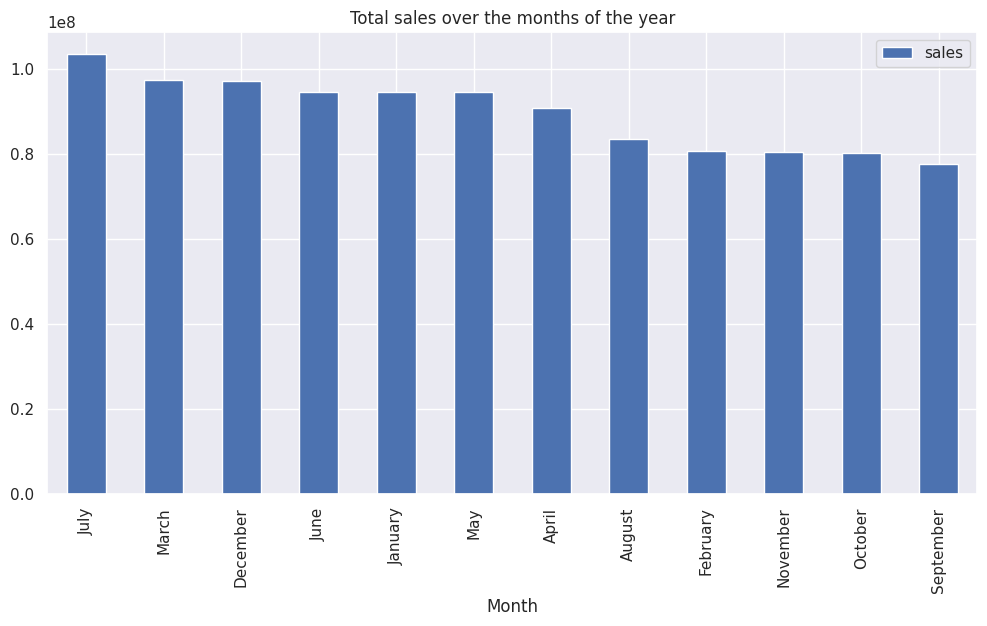

In [68]:
# plot the sum of sales by month of the year

ax = purchase_month.plot("Month", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the months of the year")

July(Summer) has the highest sales, followed by march (probaly easter), and december

Sales by Day of the week

In [70]:
# group the sum of sales by day of the week
# which day has the highest sales?

purchase_day = train_data.groupby("Day", as_index=False)["sales"].sum().sort_values(by="sales", ascending=False)
purchase_day = purchase_day.reset_index(drop=True)
purchase_day

,Day,sales
0,Sunday,1.980523e+08
1,Saturday,1.861015e+08
2,Monday,1.488278e+08
3,Wednesday,1.423787e+08
4,Friday,1.390978e+08
5,Tuesday,1.379221e+08
6,Thursday,1.212646e+08


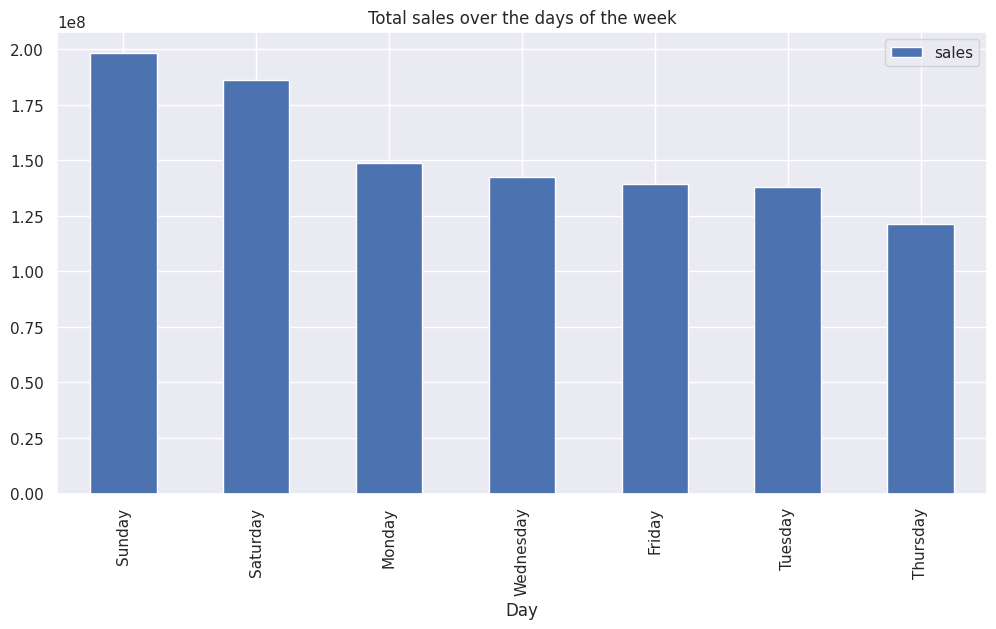

In [71]:

# plot the sum of sales by day of the week

ax = purchase_day.plot("Day", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the days of the week")

Sunday and saturday (weekends) have the highest sales


Sales by season

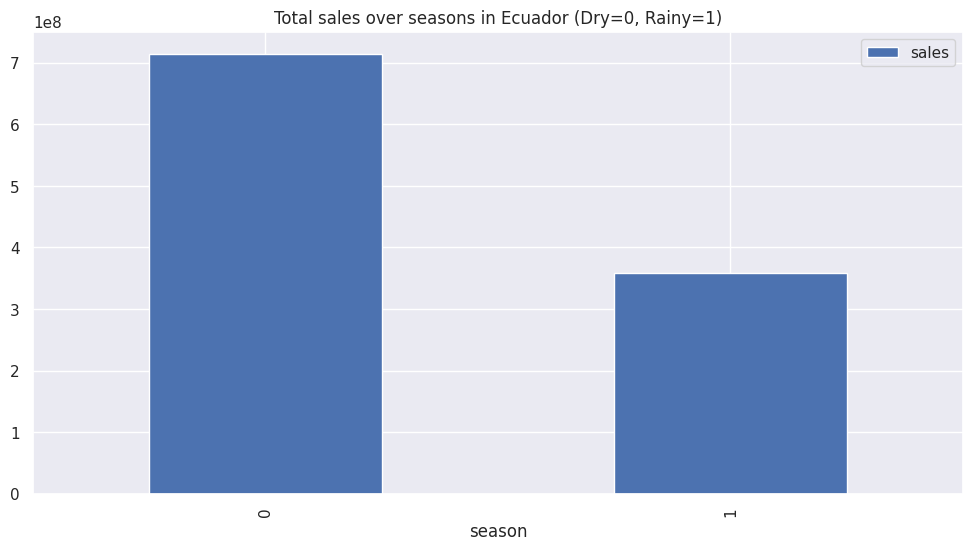

In [72]:
# create column for rainy and dry season

train_data["season"] = np.where(train_data["month"].isin([6,7,8,9]), 1, 0)

# plot sum of sales by season of the year (Dry or Rainy)
sales_by_season = train_data.groupby(["season"], as_index=False)['sales'].sum()

ax = sales_by_season.plot("season", "sales", kind="bar", figsize=(12, 6),
                          title="Total sales over seasons in Ecuador (Dry=0, Rainy=1)")

Tropical countries like Ecuador have 2 seasons (Dry and rainy)
Dry season has higher sales compared to rainy season

Sales by quarter

In [ ]:
# plot the sum of sales by quarter of the year

sales_by_quarter = train_data.groupby(["quarter"], as_index=False)['sales'].sum()

ax = sales_by_quarter.plot("quarter", "sales", kind="bar", figsize=(12, 6),
                          title="Total sales by quarter")

In [73]:
# encode categorical features

train_copy['onpromotion_encoded'] = np.where(train_copy['onpromotion'] >= 1, 1, 0)
train_copy['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    1450446
1     611312
Name: count, dtype: int64

In [74]:
# Extract the sales of products when they are on promotion and when they are not
sales_on_promotion = train_copy[train_copy['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = train_copy[train_copy['onpromotion_encoded'] == 0]['sales']

# Calculate the sample sizes
n1 = len(sales_on_promotion)
n2 = len(sales_not_on_promotion)

# Calculate the degrees of freedom
degrees_of_freedom = n1 + n2 - 2  # Assuming equal variances, subtract 2 for two samples

# Set the significance level
alpha = 0.05

# Calculate the critical t-values for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, degrees_of_freedom)

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(sales_on_promotion, sales_not_on_promotion)

# Print the t-statistic, p-value, degrees of freedom, and critical t-values
print("t-statistic:", t_stat)
print("p-value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)
print(f"Critical t-value (α = {alpha/2}):", -critical_t_value)  # Left tail
print(f"Critical t-value (α = {alpha/2}):", critical_t_value)   # Right tail

# Check if the absolute t-statistic falls within the critical value range
if t_stat >= -critical_t_value and t_stat <= critical_t_value:
    print("\nThe absolute t-statistic falls within the critical value range.")
else:
    print("\nThe absolute t-statistic does not fall within the critical value range.")

t-statistic: 466.1532931598274
p-value: 0.0
Degrees of Freedom: 2061756
Critical t-value (α = 0.025): -1.9599651351478848
Critical t-value (α = 0.025): 1.9599651351478848

The absolute t-statistic does not fall within the critical value range.


The absolute t-statistic does not fall within the critical value range.
There is a statistically significant difference in sales between products when they are on promotion and when they are not on promotion (p-value < 0.05) and the t-statistic does not fall within the critical value range
We have strong evidence to reject the null hypothesis!!

Chi-Squared contingency test
The chi-squared statistic measures the strength of the association or dependence between the two categorical variables

In [75]:

# Create contingency table
contingency_table = pd.crosstab(train_copy['onpromotion_encoded'], train_copy['sales'])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Chi-squared statistic: ", chi2)
print("p-value: ", p)

Chi-squared statistic:  853431.6902295031
p-value:  0.0


This indicates a strong association between the onpromotion and sales.